## Notebook to design PLPs for ISS 


### Requirements to run the script

This script aims to be used as an example of how to design ISS probes to target different genes. The requirements to use this scripts to design PLP are:

(1) A list of Genes to design a padlock probe (PLP) agains it

(2) The reference transcriptome of the species you are targeting in fasta format (.fasta/.fa/.fna) downloaded locally.

(3) ClustalW2 downloaded on your computer

(4) Cutadapt downloaded on your computer 


# Import packages

The first step in this script is to load the packages that the script will need. If anything fails in this step, it means most likely that you haven't installed the package yet. You can install packages with "pip install < whatever >" on the command line

In [1]:
import pandas as pd 
import Bio
from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import ClustalwCommandline
import collections
from Bio import AlignIO
import random
import numpy as np
import sys
sys.path += [r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\PLP_design_package\bin"]
#print (sys.path)
import PLP_design as plp

##  Reference parameters

Please specify in the following lines where your input csv, output path and accompaning software is located in your computer

`Path`: Where do you want your output to be stored in.
`Genes`: csv containing the list of genes you want to design PLPs against
`Pathclustal`: path where the program ClustalW2 is installed. Find it by searching ClustalW2 on your folder menu, opening the location of it and copying the path here
`ref`: reference transcriptome of the species you are interested on
 `L_probe_library`:this is used to link your good target sequences/genes to L-IDs that will be used later for decoding)
`LbarID` is,from the reference PLP list,  where do you want to start from

In [2]:
path='C:/Users/sergio.salas/Documents/PhD/projects/gene_design/hower_example_5'
genes=pd.read_csv(r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\genelist2.csv",sep=',')
pathclustal=r"C:/ProgramData/Microsoft/Windows/Start Menu/Programs/ClustalW2/ClustalW2.lnk"
ref='C:/Users/sergio.salas/Documents/PhD/projects/gene_design/example/GRCh38_latest_rna.fna'
L_probe_library="C:/Users/sergio.salas/Documents/PhD/projects/gene_design/example/Lprobe_Ver2.csv"
LbarID=201 # 

# PARAMETERS RELATED WITH PLP DESIGN ITSELF

`selgenes`: number of sequences (out of the ones fitting your parameters), that you want to map against the transcriptome.
The more you map, the slower it will be, but the higher chance you'll have to get specific sequences.
We recommend `number_of_seqs`=7-8, for a standard ISS experiment where you want 4-5 final PLPs

`final_designed`: maximum number of PLPs that you want to design out of the number included as selgenes
`plp_length`: length of the part of the PLP hybridizing the RNA molecules
`mismatches`: is the maximum allowed mismatches between the probe and the target sequence. Anything below or equal to `mismatches` will produce a positive hit. OPTIONAL: include gc_max, gc_min, set to 50 and 65 in the default script if you want to change it 

In [3]:
number_of_seqs= 2 # number of sequences mapped/PLP
final_designed=2 # number of PLPs designed at the end/gene
plp_length=30
mismatches = 5

# Extract and align sequences

The first step in the PLP design is to extract the sequnces for the designed genes from the reference transcriptome. Since many of the genes present more than one variant, the default script for PLP design will use only the common sequences

Starting MSI2



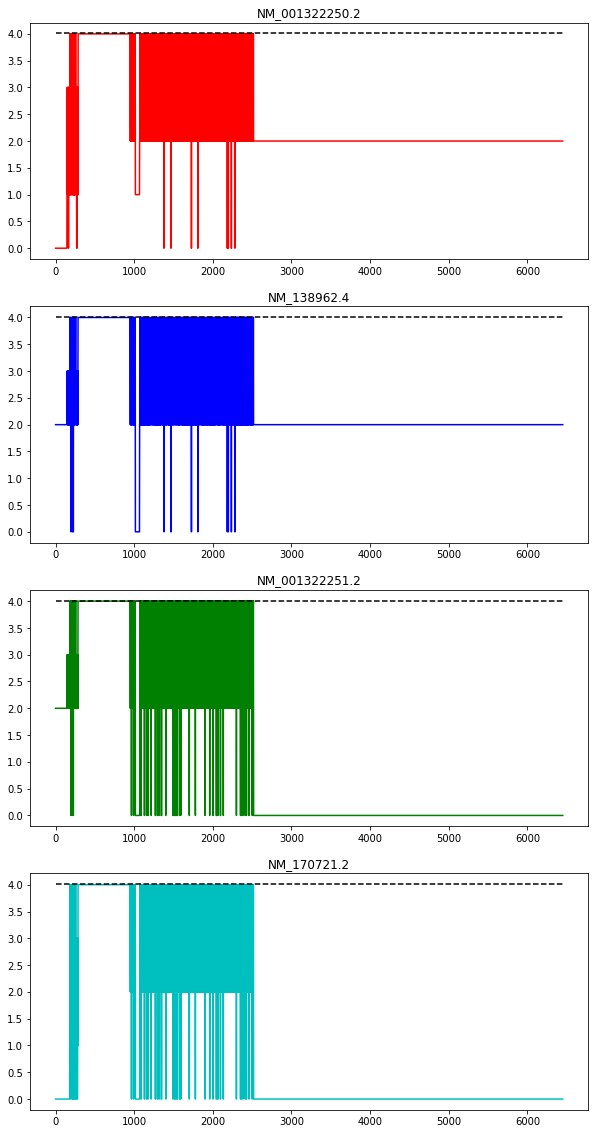

In [6]:
selection='MSI2'
genesexp,variantsID,number_of_variants=plp.extract_align_variants(genes,ref,path,pathclustal,selection)

selection of the variants that interest us

In [7]:
variantsID[0]=variantsID[0][2:4]

In [8]:
sequences,found_genes,notfound_genes=plp.extract_seqs_for_variants(path,genesexp,variantsID,number_of_variants,ref,pathclustal)

Starting MSI2



NameError: name 'ClustalwCommandline' is not defined

In [ ]:
def extract_seqs_for_variants(path,genesexp,listo,lista):
    outfiles=[]
    for holi in range(0,len(genesexp)):
        ie=0
        notfound=[]
        refpath=path+"/gene_info/"+genesexp[holi]
        if lista[holi]<2:
            if lista[holi]==0:
                print("Gene "+genesexp[holi] +" was not found")
                notfound.append(genesexp[holi])
            if lista[holi]==1:
                gen=genesexp[holi]
                goi=listo[holi]
                print('Starting '+gen)
                refpath=path+'/gene_info'+'/'+gen
                import os
                if not os.path.exists(refpath):
                    os.makedirs(refpath)
                seqs=extractseq(goi,ref)
                with open(refpath+'/seqs.fasta', 'w') as f:
                    comseq=1
                    for item in seqs:
                        f.write(">"+ gen+ " Seq"+str(comseq)+ "\n" )
                        f.write("%s\n" % item)
                        comseq=comseq+1
                    records=[]
                for ia in range(0,len(goi)-1):
                    records.append(SeqRecord(Seq(seqs[ia]),id=goi[ia]))       
                ie=0
                for seq_record in SeqIO.parse(refpath+"/seqs.fasta", "fasta"):
                    ie=ie+1
                    seq_record = seq_record.upper()
                    targetsall,outfiles = findtargets(seq_record,refpath,ie,outfiles)       
        else:   
            gen=genesexp[holi]
            goi=listo[holi]
            print('Starting '+gen)
            print()
            refpath=path+'/gene_info'+'/'+gen
            import os
            if not os.path.exists(refpath):
                os.makedirs(refpath)
            seqs=extractseq(goi,ref)
            with open(refpath+'/seqs.fasta', 'w') as f:
                for item in seqs:
                    f.write("%s\n" % item)
            clustalw_exe = pathclustal
            cmd = ClustalwCommandline(clustalw_exe,
            infile=refpath+'/seqs.fasta')
            stdout, stderr = cmd()
            alignment = AlignIO.read(refpath+'/seqs.aln', "clustal")
            st=''
            cseqs=[]
            common=[]
            for esa in range(0,alignment.get_alignment_length()):
                un=alignment[:,esa]
                col=collections.Counter(un).most_common(1)[0]
                common.append(col[1])
                if col[1]==len(alignment):
                    st=st+str(col[0])
                else:
                    if len(st)>35:
                        cseqs.append(st)
            #            cseqs=[]
                        st=''
            if len(st)>35:
                        cseqs.append(st)
                        st=''
            plot_alignment(refpath,alignment,common)
            with open(refpath+'/aligned_seqs.fasta', 'w') as f:
                comseq=1
                for item in cseqs:
                    f.write(">"+ gen+ " Seq"+str(comseq)+ "\n" )
                    f.write("%s\n" % item)
                    comseq=comseq+1
            records=[]
            for ia in range(0,len(goi)-1):
                records.append(SeqRecord(Seq(seqs[ia]),id=goi[ia]))       
            # Loads fasta
            ie=0
            for seq_record in SeqIO.parse(refpath+"/aligned_seqs.fasta", "fasta"):
                seq_record = seq_record.upper()
                #print (seq_record)
                ie=ie+1
                targetsall,outfiles = findtargets(seq_record,refpath,ie,outfiles)
    #           print(targetsall)
    of=pd.DataFrame(outfiles)
    of.to_csv(path+'/outfiles.csv')
    selected,unigene=retrieve_targets(outfiles,path)
    hits=dict(zip(genesexp,lista))
    selected['exp_hits']=selected['Gene'].map(hits)
    return selected,unigene,notfound


In [ ]:

def extract_seqs_for_variants(path,genesexp,listo,lista,ref,pathclustal):
    import pandas as pd 
    import Bio
    from Bio import SeqIO
    from Bio.SeqUtils import GC
    from Bio.Seq import Seq
    from Bio.SeqRecord import SeqRecord
    from Bio.Align import MultipleSeqAlignment
    from Bio.Align.Applications import ClustalwCommandline
    import collections
    from Bio import AlignIO
    import random
    import numpy as np
    outfiles=[]
    for holi in range(0,len(genesexp)):
        ie=0
        notfound=[]
        refpath=path+"/gene_info/"+genesexp[holi]
        if lista[holi]<2:
            if lista[holi]==0:
                print("Gene "+genesexp[holi] +" was not found")
                notfound.append(genesexp[holi])
            if lista[holi]==1:
                gen=genesexp[holi]
                goi=listo[holi]
                print('Starting '+gen)
                refpath=path+'/gene_info'+'/'+gen
                import os
                if not os.path.exists(refpath):
                    os.makedirs(refpath)
                seqs=extractseq(goi,ref)
                with open(refpath+'/seqs.fasta', 'w') as f:
                    comseq=1
                    for item in seqs:
                        f.write(">"+ gen+ " Seq"+str(comseq)+ "\n" )
                        f.write("%s\n" % item)
                        comseq=comseq+1
                    records=[]
                for ia in range(0,len(goi)-1):
                    records.append(SeqRecord(Seq(seqs[ia]),id=goi[ia]))       
                ie=0
                for seq_record in SeqIO.parse(refpath+"/seqs.fasta", "fasta"):
                    ie=ie+1
                    seq_record = seq_record.upper()
                    targetsall,outfiles = findtargets(seq_record,refpath,ie,outfiles)       
        else:   
            gen=genesexp[holi]
            goi=listo[holi]
            print('Starting '+gen)
            print()
            refpath=path+'/gene_info'+'/'+gen
            import os
            if not os.path.exists(refpath):
                os.makedirs(refpath)
            seqs=extractseq(goi,ref)
            with open(refpath+'/seqs.fasta', 'w') as f:
                for item in seqs:
                    f.write("%s\n" % item)
            clustalw_exe = pathclustal
            cmd = ClustalwCommandline(clustalw_exe,
            infile=refpath+'/seqs.fasta')
            stdout, stderr = cmd()
            alignment = AlignIO.read(refpath+'/seqs.aln', "clustal")
            st=''
            cseqs=[]
            common=[]
            for esa in range(0,alignment.get_alignment_length()):
                un=alignment[:,esa]
                col=collections.Counter(un).most_common(1)[0]
                common.append(col[1])
                if col[1]==len(alignment):
                    st=st+str(col[0])
                else:
                    if len(st)>35:
                        cseqs.append(st)
            #            cseqs=[]
                        st=''
            if len(st)>35:
                        cseqs.append(st)
                        st=''
            plot_alignment(refpath,alignment,common)
            with open(refpath+'/aligned_seqs.fasta', 'w') as f:
                comseq=1
                for item in cseqs:
                    f.write(">"+ gen+ " Seq"+str(comseq)+ "\n" )
                    f.write("%s\n" % item)
                    comseq=comseq+1
            records=[]
            for ia in range(0,len(goi)-1):
                records.append(SeqRecord(Seq(seqs[ia]),id=goi[ia]))       
            # Loads fasta
            ie=0
            for seq_record in SeqIO.parse(refpath+"/aligned_seqs.fasta", "fasta"):
                seq_record = seq_record.upper()
                #print (seq_record)
                ie=ie+1
                targetsall,outfiles = findtargets(seq_record,refpath,ie,outfiles)
    #           print(targetsall)
    of=pd.DataFrame(outfiles)
    of.to_csv(path+'/outfiles.csv')
    selected,unigene=retrieve_targets(outfiles,path)
    hits=dict(zip(genesexp,lista))
    selected['exp_hits']=selected['Gene'].map(hits)
    return selected,unigene,notfound


From the previous script, we return `sequences`, which include all the potential sequences (not mapped yet) for all genes targeted. `found_genes` include the list of genes that we have been able to find k-mers fullfiling the PLP requirements. `not_found_genes` include the list of genes that we haven't been able to find/ we haven't been able to find any k-mer that fullfils the requirements. Those can be (1) too short genes or (2) genes with too many variants and no comon sequence among them

# Select a subsample of potential targets

We subsample the long list of potential targets/sequences to check for specificity. The returned object `selected_sequences` has the same format as sequences, but has only the amount of targets/gene specified in `number_of_seqs`

In [28]:
selected_sequences=plp.select_sequences(path,sequences,found_genes,number_of_seqs,subgroup='variant_1')

In [7]:
def map_sequences(selected,subgroup=1):
    kmers =list(selected['Sequence'])
    transcriptome = (ref)
    seqlist = []
    hitlist = []
    lenlist = []
    s=0
    for sequence in kmers:
        s=s+1
        print ('Looking for sequence ('+str(s)+'/'+str(len(kmers))+'): '+sequence + ' allowing ' + str(mismatches) + ' mismatches')
        output= !C:/Users/sergio.salas/Downloads/cutadapt-3.4.exe -a $sequence --overlap 30 $transcriptome --no-indels -e $mismatches --action=retain --untrimmed-output C:\Users\sergio.salas\Downloads\here  
        n=0
        c2 = [line for line in output if line[0:1] == '>']
        print ('Found '+str(len(c2))+' hits')
        seqlist.append (sequence)
        hitlist.append (c2)
        lenlist.append (len(c2))
    expoutput = pd.DataFrame(list(zip(seqlist, hitlist, lenlist)),
                   columns =['sequence_with_Ns', 'hits', 'number_of_hits'])
    bcf_all=pd.concat([selected.reset_index(),expoutput],axis=1)
    bcf_all.to_csv(path+'mapped_sequences'+str(subgroup)+'.csv')
    return bcf_all

In [8]:
sel_mapped_seqs=map_sequences(selected_sequences,subgroup=1)

Looking for sequence (1/6): GTGGTCAGTCTTCATGCAGCAGCCAACAGT allowing 5 mismatches
Found 3 hits
Looking for sequence (2/6): GTGGAACGAAGTCAGCTCCGGAAGCGCCGA allowing 5 mismatches
Found 3 hits
Looking for sequence (3/6): CTGCCTTACACCATGGACGCGTTCATGCTT allowing 5 mismatches
Found 11 hits
Looking for sequence (4/6): GGTGGACTGAGCTGGCAGACCTCACCAGAT allowing 5 mismatches
Found 9 hits
Looking for sequence (5/6): GAGGCTCAGCTAACGCTCAACAGCTACATC allowing 5 mismatches
Found 2 hits
Looking for sequence (6/6): CAAGATGAGGCTCAGCTAACGCTCAACAGC allowing 5 mismatches
Found 2 hits


# Check the amount of specific sequences for each gene

After mapping the sequences against the reference genome, we check how many genes have all PLPs that we asked for ( `genes_good_PLPs` ), how many have less than expected (`genes_too_low_PLPs`) and how many have none ( `genes_no_PLPs` ). If we add to this groups, the list of `notfound_genes` where we couldn't design any k-mer against, all the genes we tested should fall under one of this categories. This is:
* `notfound_genes`: genes either not found in the transcriptome OR without a common sequence in all variants/too short genes. We suggest to explore this genes further more to check if it's a naming problem or if it's a gene that is not suitable for ISS
* `genes_no_PLPs`: potential k-mers have been found for that gene, but none has proven to be specific. Try rerunning `plp.select_sequences` but with a larger `number_of_seqs`. If genes persist in this list, it can mean that they do not have specific k-mers suitable for ISS due to lack of specificity
* `genes_too_low_PLPs`: some potential k-mers have been found for this genes but they are not enough. Rerunning `plp.select_sequences` but with a larger `number_of_seqs` should really make it. Otherwise, consider ordering less PLPs for your gene of interest
* `genes_good_PLPs`: you have everything that you needed for those genes

In [9]:
specific_seqs1,genes_good_PLPs, genes_too_low_PLPs, genes_no_PLPs=plp.check_plps(sel_mapped_seqs,final_designed,genes,path,subgroup=1)

# RUN2 : looking for specific k-mers for genes missing (subgroup 2)

It's possible that you have group of genes that do not have enough specific k-mers in the first run. For these groups (present in `genes_too_low_PLPs` and `genes_no_PLPs` we will run another round of selection of potential k-mers to check their specificity. For this reason, we'll now modify the parameter `number_of_seqs` to be larger. This is considered as **`subgroup`=2** , and it's important to specify it in the functions. 

In [10]:
genes_to_redesign=list(genes_too_low_PLPs.index) # add genes_no_PLPs if needed to this list
number_of_seqs=1

In [11]:
selected_sequences2=plp.select_sequences(path,sequences,found_genes,number_of_seqs,subgroup=2)

In [12]:
sel_mapped_seqs2=map_sequences(selected_sequences2,subgroup=2)

Looking for sequence (1/3): ACTCCAAGGCTGTGTGTGCACCAGCCAGAG allowing 5 mismatches
Found 1 hits
Looking for sequence (2/3): ACTGCCTTACACCATGGACGCGTTCATGCT allowing 5 mismatches
Found 11 hits
Looking for sequence (3/3): CTCTACTGGCTGTATCTGGCATGAACGGTG allowing 5 mismatches
Found 2 hits


In [13]:
specific_seqs2,genes_good_PLPs2, genes_too_low_PLPs2, genes_no_PLPs2=plp.check_plps(sel_mapped_seqs2,final_designed,genes,path,subgroup=2)

# Combine the specific sequences from different subgroups

After we got the specific sequences for more than 1 run, we'd like to combine them to get a final list

In [14]:
final_seqs=pd.concat([specific_seqs1,specific_seqs2],axis=0)

In [15]:
specific_seqs_final,genes_good_PLPs_final, genes_too_low_PLPs_final, genes_no_PLPs_final=plp.check_plps(final_seqs,final_designed,genes,path,subgroup='final')

# Assign Gene to Barcode

 Once we have specific targets for all genes, we can build the PLPs. For this, we use L_library_v2 as reference. By modifying the parameter `how`, we can select how to assign genes to Lbar_IDs.
 * We can  select `how='start'` and then set `on` to the first ID to assign to your gene.
 * We can  select `how='end'` and then set `on` to the last ID to assign to your gene.
 * We can also select `how='customized'` and provide as `on` the path to the csv with two columns, one for "Gene", and the other for "Lbar_ID"
 

In [16]:
customizedlib=r"C:\Users\sergio.salas\Documents\PhD\projects\gene_design\hower_example_5\assigned_gene_LID.csv"
probes=plp.build_plps(path,specific_seqs_final,L_probe_library,plp_length,how='customized',on=customizedlib)

I just processed 9 unique target sequences. I am done


In [17]:
probes

,sequence,Lbar_ID,AffyID,Gene,code
0,CTGACTTCGTTCCACACGTGCCTAAAGTGTACTACTGCGTCTATTT...,LbarID_0227,Afy16K_ID2081,GLI3,232311
1,ATGAAGACTGACCACACGTGCCTAAAGTGTACTACTGCGTCTATTT...,LbarID_0227,Afy16K_ID2081,GLI3,232311
2,CATGGTGTAAGGCAGAGGTCTTGACAATAAGGACGTGCGTCTATTT...,LbarID_0229,Afy16K_ID2086,MSI2,441111
3,ATGGTGTAAGGCAGTAGGTCTTGACAATAAGGACGTGCGTCTATTT...,LbarID_0229,Afy16K_ID2086,MSI2,441111
4,CTGAGCCTCATCTTGAGGTCGTTAAGAGGCAATACTGCGTCTATTT...,LbarID_0228,Afy16K_ID2085,NR2E1,111211
5,CGTTAGCTGAGCCTCAGGTCGTTAAGAGGCAATACTGCGTCTATTT...,LbarID_0228,Afy16K_ID2085,NR2E1,111211
